In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import torch
torch.manual_seed(0)

%load_ext autoreload 
%autoreload 2
%config InlineBackend.figure_format = 'retina'

/home/gridsan/mmurphy/.conda/envs/HumanProteinAtlas/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
EMBEDDINGS = 'kidney_embeddings'
embeddings = np.load(f'./data/{EMBEDDINGS}.npy')
index = !cat ./data/{EMBEDDINGS}.txt
embeddings = pd.DataFrame(embeddings,index=index)

rna = pd.read_csv('./data/kidney_rna.csv',index_col=0)

df = pd.read_csv('./data/hpa_v21_kidney.csv',index_col=0)
df['duplicated'] = df.index.value_counts()[df.index] > 1
df = ( df.query('(Staining=="high")|(Staining=="medium")')
         .query('Reliability=="Enhanced"')
         .query('~duplicated') )

adata = embeddings.join(df, how='inner')
adata = sc.AnnData(adata[embeddings.columns], obs=adata[df.columns])
adata.var_names = pd.Series(range(adata.shape[1])).astype(str)
adata.obs = adata.obs.join(rna, on='Gene', how='left')
adata.obs['rna_cell_type'] = adata.obs[rna.columns].idxmax(1)
adata.obs['rna_specificity'] = adata.obs[rna.columns].max(1)

adata

AnnData object with n_obs × n_vars = 10164 × 128
    obs: 'Batch', 'Slide', 'Well', 'Tissue', 'Gene name', 'Gene', 'UniProt', 'Antibody', 'nTPM', 'Staining', 'Sex', 'Age', 'Patient', 'URL', 'Level', 'Reliability', 'duplicated', 'epithelial cell of proximal tubule', 'fibroblast', 'glomerular visceral epithelial cell', 'kidney capillary endothelial cell', 'kidney connecting tubule epithelial cell', 'kidney distal convoluted tubule epithelial cell', 'kidney loop of Henle thick ascending limb epithelial cell', 'leukocyte', 'mesangial cell', 'parietal epithelial cell', 'renal alpha-intercalated cell', 'renal beta-intercalated cell', 'renal principal cell', 'rna_cell_type', 'rna_specificity'

In [3]:
sc.pp.neighbors(adata, use_rep='X')
sc.tl.umap(adata, min_dist=0.5)

Compare dimensionality-reduced structure to transcriptional specificity

In [4]:
from figures.cell_type_colors import cell_type_colors

adata.obs['rna_cell_type'] = ( adata.obs['rna_cell_type']
                                    .astype('category')
                                    .cat
                                    .reorder_categories(list(cell_type_colors)) )

... storing 'Well' as categorical
... storing 'Tissue' as categorical
... storing 'Gene name' as categorical
... storing 'Gene' as categorical
... storing 'UniProt' as categorical
... storing 'Antibody' as categorical
... storing 'Staining' as categorical
... storing 'Sex' as categorical
... storing 'Level' as categorical
... storing 'Reliability' as categorical


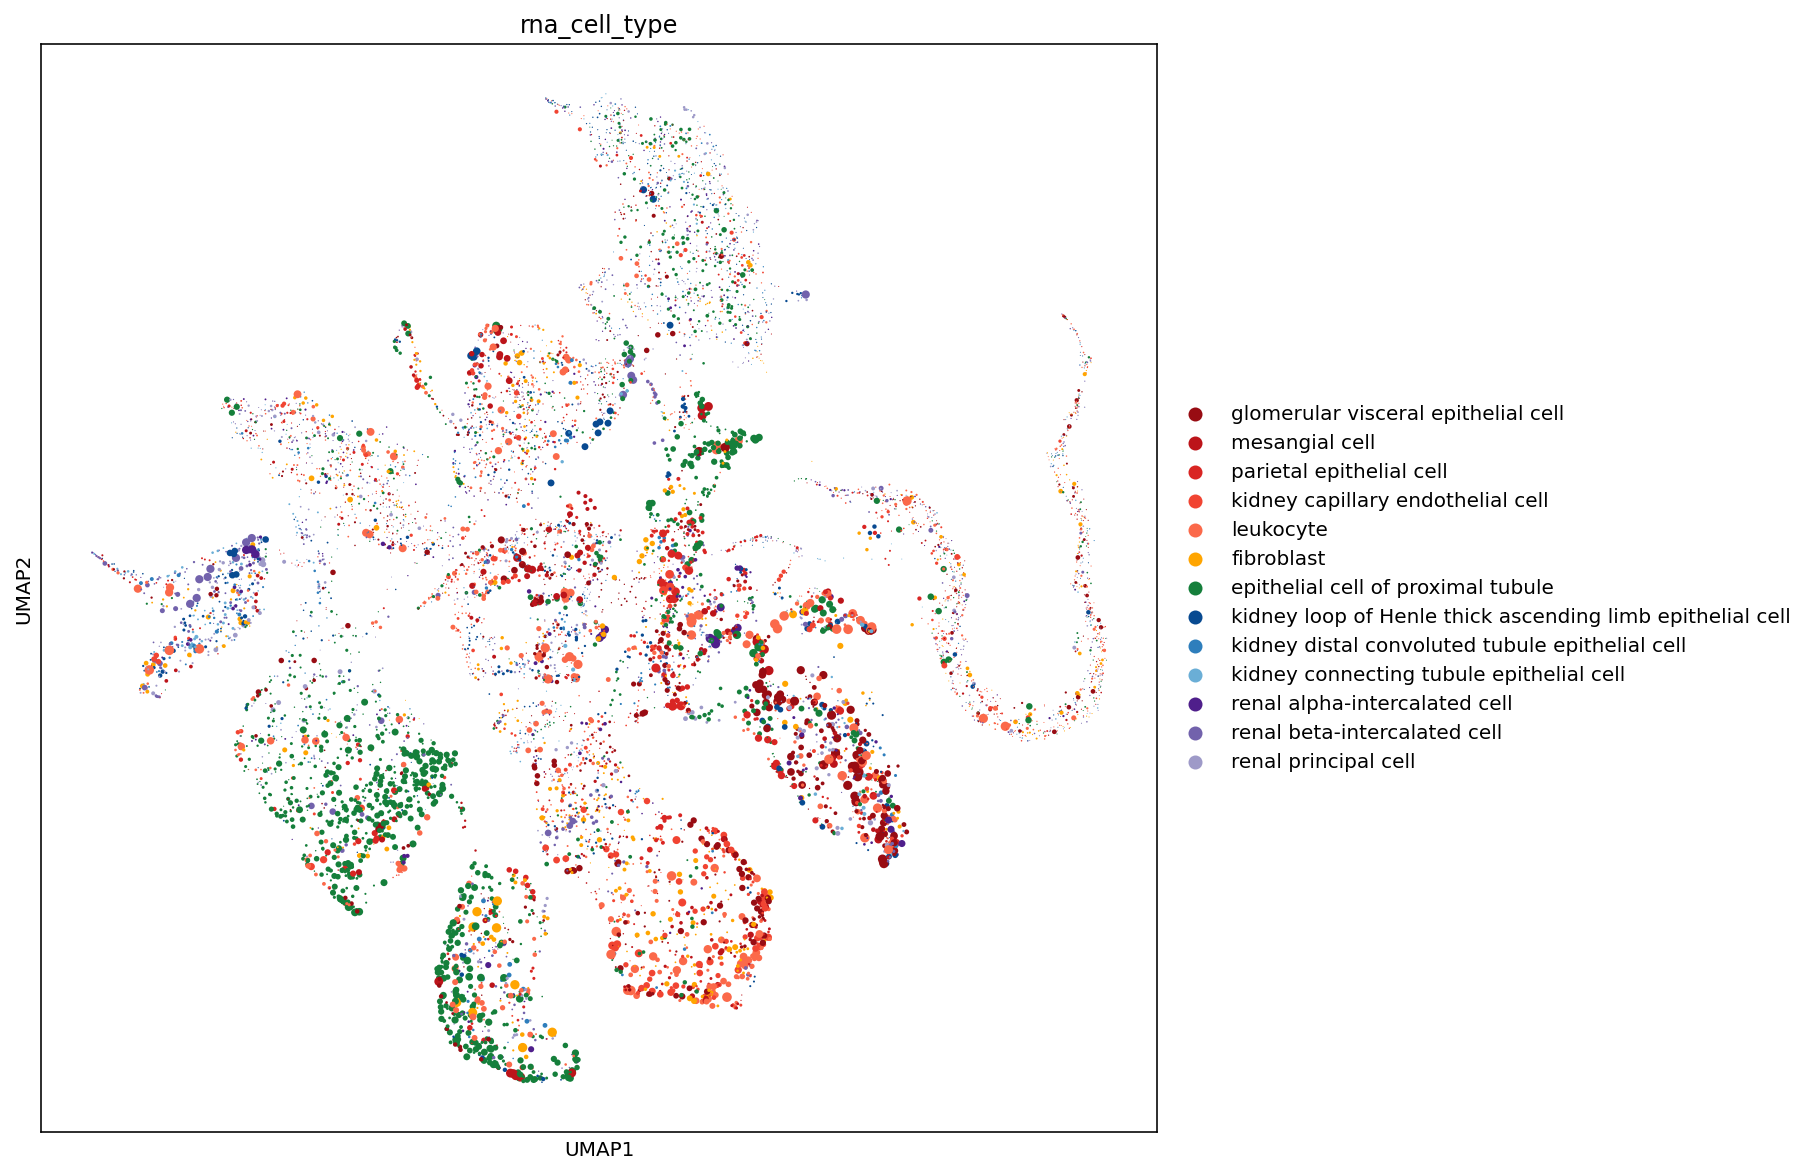

In [5]:
fig, ax = plt.subplots(figsize=(10,10))
sc.pl.umap(
    adata, 
    color=['rna_cell_type'], 
    palette=cell_type_colors, 
    ax=ax, 
    s=adata.obs['rna_specificity']**2*100,
    na_in_legend=False,
    show=False
)
plt.savefig('./figures/umap.png', dpi=300)

Leiden clusters

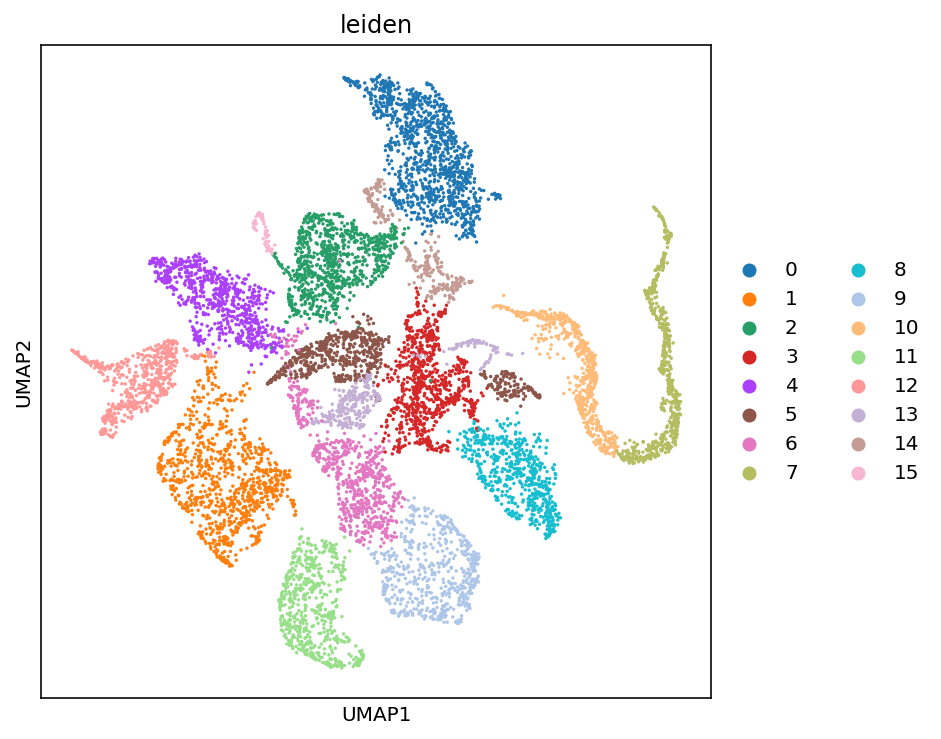

In [6]:
sc.tl.leiden(adata, resolution=0.2)

sc.pl.umap(adata, color='leiden', ax=plt.subplots(figsize=(6,6))[1])

Donor mixing

... storing 'Patient' as categorical


AMI between Leiden cluster and donor 0.012281737052788032


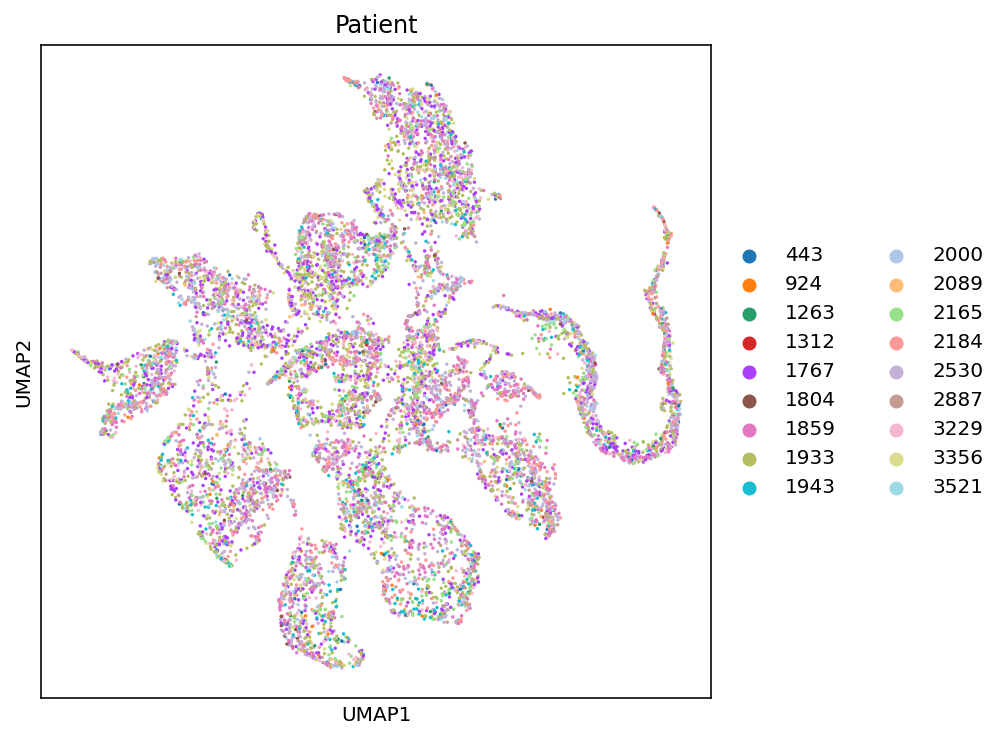

In [7]:
from sklearn.metrics import adjusted_mutual_info_score

adata.obs['Patient'] = adata.obs['Patient'].astype(str)
sc.pl.umap(adata,color=['Patient'],ax=plt.subplots(figsize=(6,6))[1],show=False)
plt.savefig('./figures/donors.png', dpi=300)

ami = adjusted_mutual_info_score(
    adata.obs['leiden'], 
    adata.obs['Patient']
)
print('AMI between Leiden cluster and donor', ami)

In [8]:
# !mkdir -p ./scratch
# adata.write('./scratch/processed.h5')